In [1]:
EXPERIMENTS_PATH = '/kaggle/input/rlprompt-yelp5/rl-prompt/examples/few-shot-classification/outputs/2025-04-11'
LOG_PATH = '/kaggle/input/rlprompt-yelp5/all_outputs_yelp5.log'

## Get Prompts Token

In [2]:
import os
import json

def find_max_output_tokens(root_dir):
    results = []
    
    # Process each subdirectory
    for subdir_entry in os.scandir(root_dir):
        if not subdir_entry.is_dir():
            continue

        searched_path = os.path.join(subdir_entry.path, 'outputs', 'eval')

        subdir_info = {
            "subdirectory": searched_path,
            "max_output_token": None,
            "max_score": float('-inf')
        }

        # Scan JSON files in the subdirectory
        for filename in os.listdir(searched_path):
            if not filename.endswith('.json'):
                continue

            filepath = os.path.join(searched_path, filename)
            
            try:
                with open(filepath, 'r') as f:
                    data = json.load(f)
                    current_score = data.get('scores', [float('-inf')])[0]
                    current_token = data.get('output_tokens', '')

                    # Update max if current score is higher
                    if current_score > subdir_info['max_score']:
                        subdir_info['max_score'] = current_score
                        subdir_info['max_output_token'] = current_token
                        
            except (json.JSONDecodeError, FileNotFoundError):
                print(f"Skipped invalid file: {filename}")
                continue

        # Add to results and print
        results.append(subdir_info)
        print(f"Directory: {subdir_info['subdirectory']}")
        print(f"Max Token: {subdir_info['max_output_token']}")
        print(f"Max Score: {subdir_info['max_score']}\n")

    return results

In [3]:
root_path = EXPERIMENTS_PATH
directory_results = find_max_output_tokens(root_path)

Directory: /kaggle/input/rlprompt-yelp5/rl-prompt/examples/few-shot-classification/outputs/2025-04-11/17-19-02/outputs/eval
Max Token: [['TextColor', 'Ġanimation']]
Max Score: -5.541043281555176



## Evaluation Figure

In [4]:
import re

# Set the path for your log file
log_file = LOG_PATH

steps = []
rewards = []
accuracy = []

step_pattern = re.compile(r'^(\d+)\s+\|')
reward_pattern = re.compile(r'([-+]?\d*\.\d+|\d+)')
accuracy_pattern = re.compile(r'Accuracy:\s*([-+]?\d*\.\d+|\d+)')

with open(log_file, 'r') as f:
    lines = f.readlines()

current_step = None

for i, line in enumerate(lines):
    step_match = step_pattern.match(line)
    if step_match:
        current_step = int(step_match.group(1))

    if "Our Prompt:" in line:
        next_line = lines[i+1].strip()
        numbers = reward_pattern.findall(next_line)
        if numbers:
            reward_value = float(numbers[-1])
            if current_step is not None:
                steps.append(current_step)
                rewards.append(reward_value)
                    
        prev_line = lines[i-1].strip()
        accuracy_match = accuracy_pattern.search(prev_line)
        if accuracy_match:
            accuracy_value = float(accuracy_match.group(1))
            if current_step is not None:
                accuracy.append(accuracy_value)


In [5]:
import matplotlib.pyplot as plt

def show_evaluation_figure_rewards(steps, rewards, seed):
    plt.style.use('seaborn-whitegrid')
    plt.figure(figsize=(10, 6))
    
    plt.plot(steps, rewards, marker='o', linestyle='-', linewidth=2, color='orange')
    
    # Add axis labels, a title, and legend
    plt.xlabel('Step Number', fontsize=14)
    plt.ylabel('Reward', fontsize=14)
    plt.title(f'Evaluation Plot: Reward vs. Steps (SEED={seed})', fontsize=16)
    plt.legend(fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Adjust layout for neatness and show the plot
    plt.tight_layout()
    plt.show()

def show_evaluation_figure_accuracy(steps, accuracy, seed):
    plt.style.use('seaborn-whitegrid')
    plt.figure(figsize=(10, 6))
    
    plt.plot(steps, accuracy, marker='o', linestyle='-', linewidth=2, color='orange')
    
    # Add axis labels, a title, and legend
    plt.xlabel('Step Number', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.title(f'Evaluation Plot: Accuracy vs. Steps (SEED={seed})', fontsize=16)
    plt.legend(fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Adjust layout for neatness and show the plot
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_19/2735163308.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


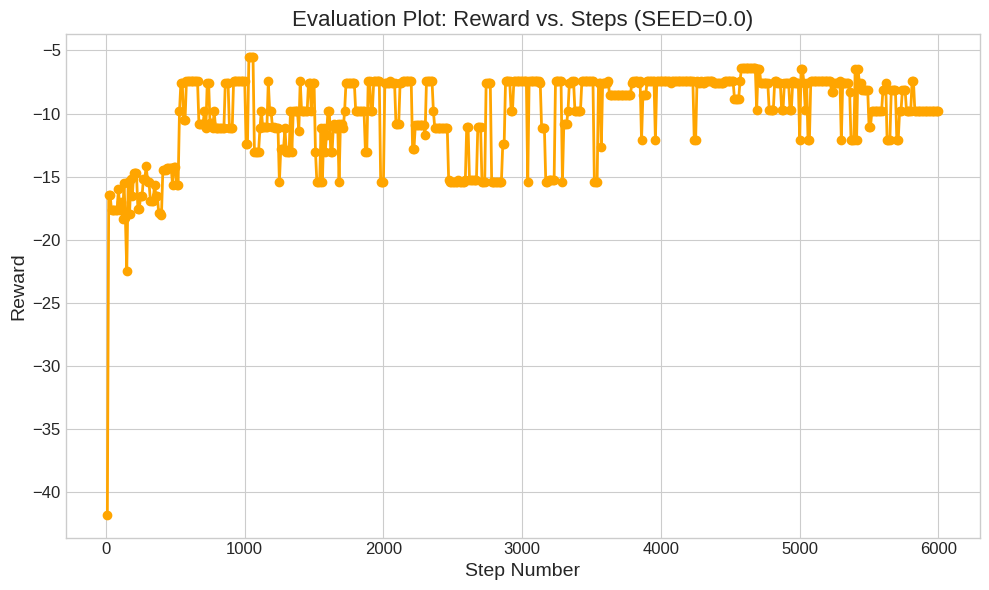

/tmp/ipykernel_19/2735163308.py:22: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


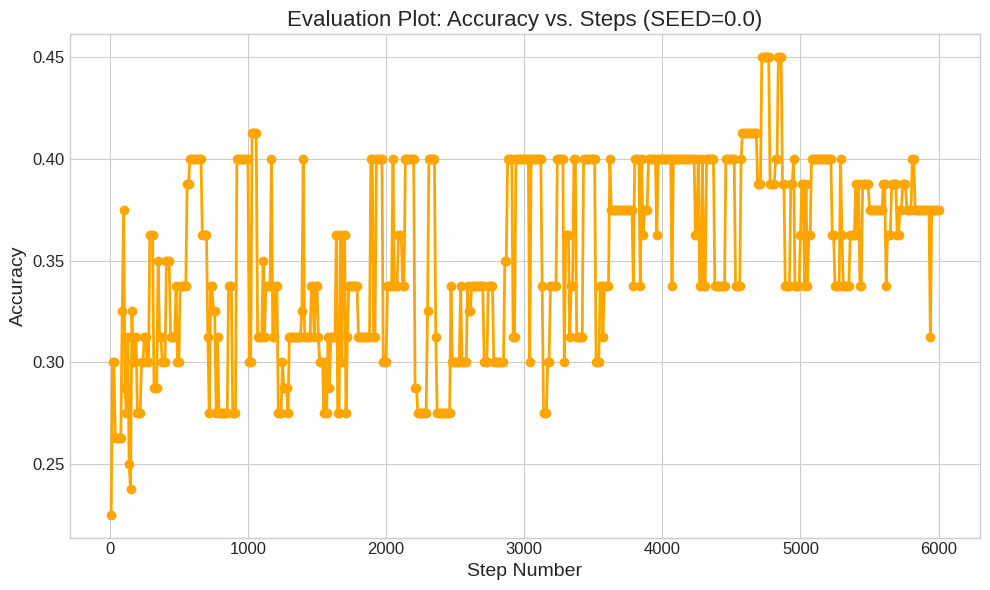

In [6]:
INTERVAL = 600

starts = 0
end = starts + INTERVAL

while end <= len(steps):
    current_steps = steps[starts:end]
    current_rewards = rewards[starts:end]
    current_accuracy = accuracy[starts:end]

    show_evaluation_figure_rewards(current_steps, current_rewards, starts/INTERVAL)
    show_evaluation_figure_accuracy(current_steps, current_accuracy, starts/INTERVAL)

    
    starts = end
    end = starts + INTERVAL

In [7]:
import numpy as np

log_file = LOG_PATH

all_rewards = {}
all_accuracy = {}

header_pattern = re.compile(r'^(\d+)\s*\|')
reward_pattern = re.compile(r'Reward:\s*([-+]?\d*\.\d+|\d+)')
accuracy_pattern = re.compile(r'Accuracy:\s*([-+]?\d*\.\d+|\d+)')

with open(log_file, 'r') as f:
    lines = f.readlines()

current_step = None
seed = -1

for line in lines:
    if 'Task LM' in line:
        seed += 1
        all_rewards[seed] = {}
        all_accuracy[seed] = {}
        continue
    
    header_match = header_pattern.match(line)
    if header_match:
        current_step = int(header_match.group(1))
    
    if "Reward:" in line:
        reward_match = reward_pattern.search(line)
        if reward_match:
            reward_value = float(reward_match.group(1))
            if current_step is not None:
                all_rewards[seed].setdefault(current_step, []).append(reward_value)

    if "Accuracy:" in line:
        accuracy_match = accuracy_pattern.search(line)
        if accuracy_match:
            accuracy_value = float(accuracy_match.group(1))
            if current_step is not None:
                all_accuracy[seed].setdefault(current_step, []).append(accuracy_value)

In [8]:
import matplotlib.pyplot as plt

def show_training_figure_rewards(steps, means, stds, seed):
    plt.style.use('seaborn-whitegrid')
    plt.figure(figsize=(10, 6))
    
    plt.plot(steps, means, marker='o', linestyle='-', linewidth=2, color='blue')
    
    # Plot the standard deviation as a shaded area (mean ± std)
    plt.fill_between(steps, 
                     np.array(means) - np.array(stds), 
                     np.array(means) + np.array(stds),
                     color='blue', alpha=0.2)
    
    # Add axis labels, a title, and legend
    plt.xlabel('Step Number', fontsize=14)
    plt.ylabel('Reward', fontsize=14)
    plt.title(f'Training Plot: Reward vs. Steps (SEED={seed})', fontsize=16)
    plt.legend(fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Adjust layout for neatness and show the plot
    plt.tight_layout()
    plt.show()

def show_training_figure_accuracy(steps, means, stds, seed):
    plt.style.use('seaborn-whitegrid')
    plt.figure(figsize=(10, 6))
    
    plt.plot(steps, means, marker='o', linestyle='-', linewidth=2, color='blue')
    
    # Plot the standard deviation as a shaded area (mean ± std)
    plt.fill_between(steps, 
                     np.array(means) - np.array(stds), 
                     np.array(means) + np.array(stds),
                     color='blue', alpha=0.2)
    
    # Add axis labels, a title, and legend
    plt.xlabel('Step Number', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.title(f'Training Plot: Accuracy vs. Steps (SEED={seed})', fontsize=16)
    plt.legend(fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Adjust layout for neatness and show the plot
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_19/3134512436.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


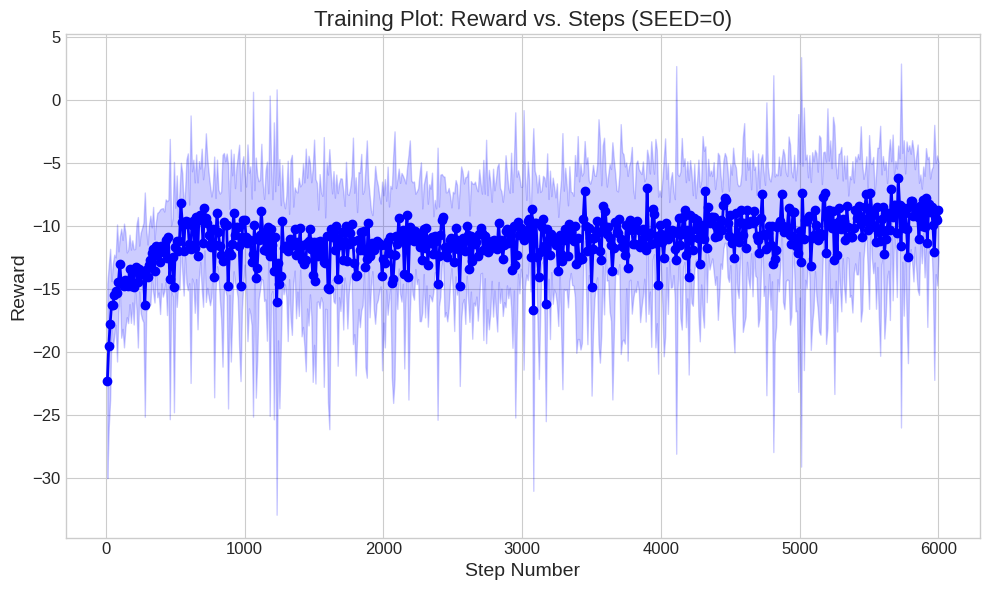

/tmp/ipykernel_19/3134512436.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


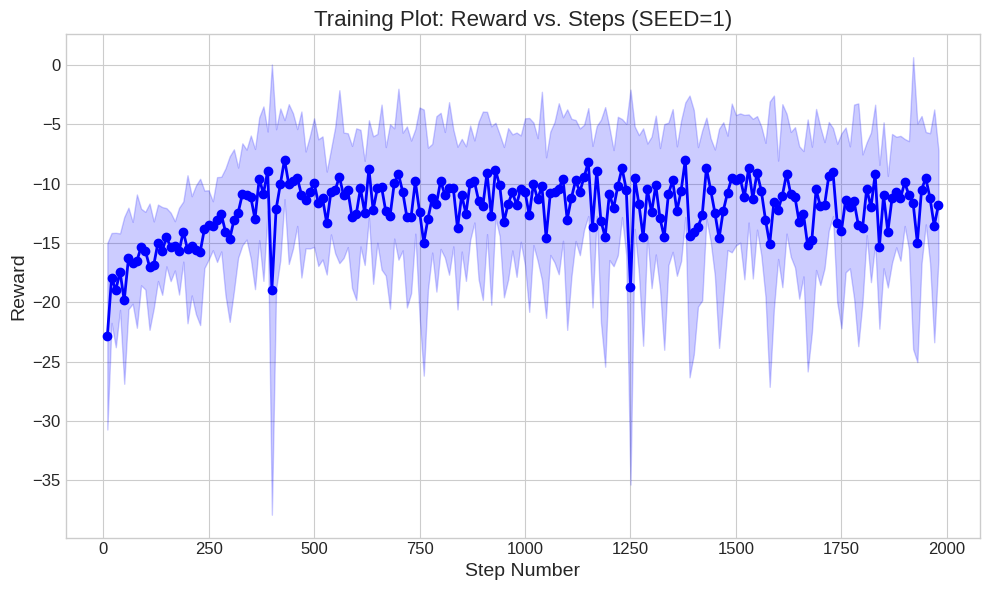

In [9]:
for seed, data in all_rewards.items():
    steps = sorted(data.keys())

    steps = [step for step in steps if step % 10 == 0]
    means = [np.mean(data[step]) for step in steps]
    stds  = [np.std(data[step]) for step in steps]

    show_training_figure_rewards(steps, means, stds, seed)

/tmp/ipykernel_19/3134512436.py:28: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


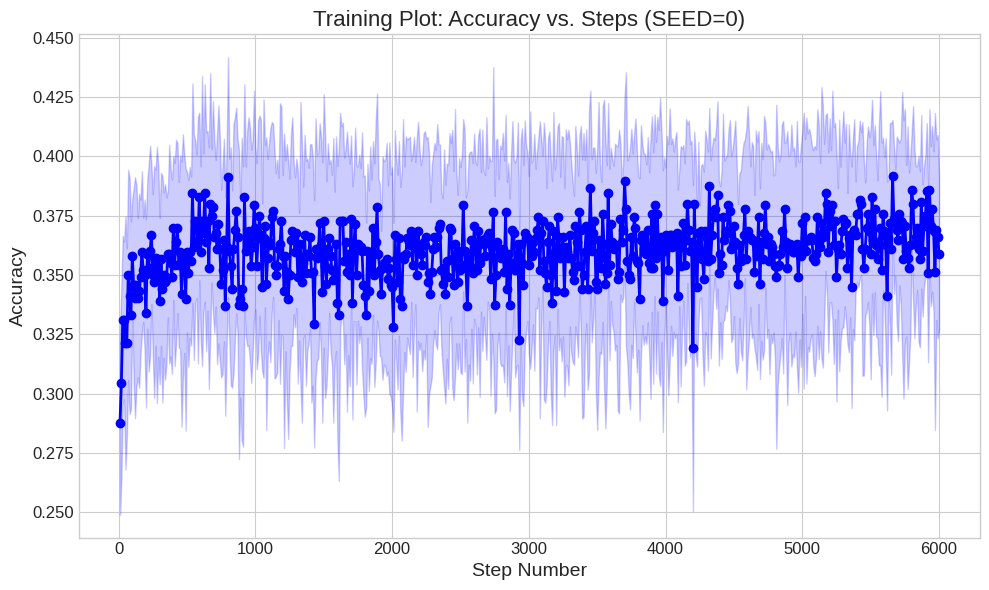

/tmp/ipykernel_19/3134512436.py:28: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


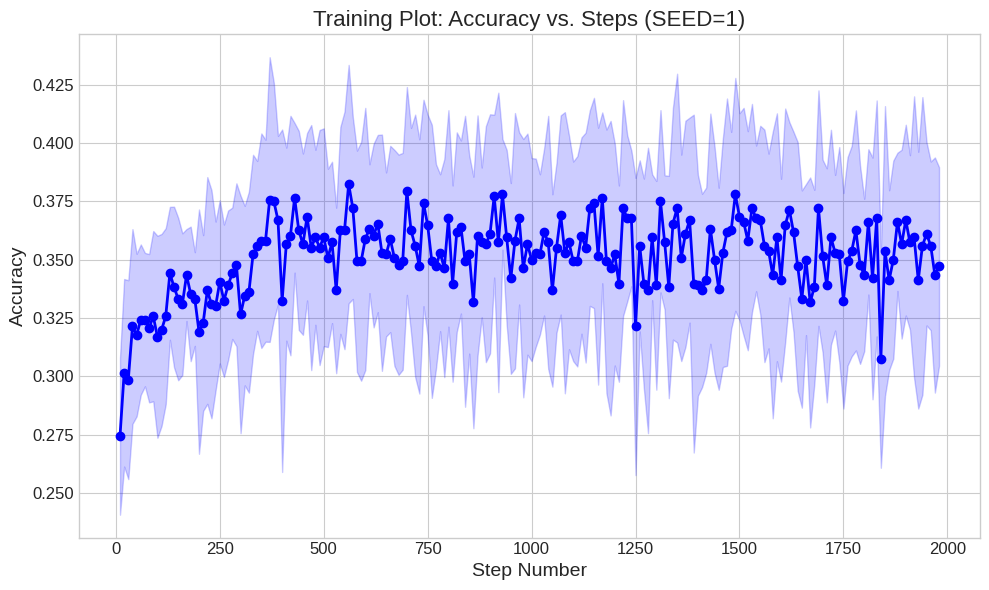

In [10]:
for seed, data in all_accuracy.items():
    steps = sorted(data.keys())

    steps = [step for step in steps if step % 10 == 0]
    means = [np.mean(data[step]) for step in steps]
    stds  = [np.std(data[step]) for step in steps]

    show_training_figure_accuracy(steps, means, stds, seed)

## Environment Prep

In [11]:
from IPython.display import clear_output

In [12]:
root_dir = "/kaggle/conda"
!mkdir -p $root_dir
!wget -q --show-progress https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
!bash Miniconda3-latest-Linux-x86_64.sh -b -p $root_dir/miniconda3 -f
clear_output()

In [13]:
!$root_dir/miniconda3/bin/conda create --name my_env python=3.10 -y
clear_output()

In [14]:
!git clone https://github.com/malifalhakim/rl-prompt.git

Cloning into 'rl-prompt'...
remote: Enumerating objects: 1425, done.
remote: Counting objects: 100% (273/273), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 1425 (delta 193), reused 160 (delta 160), pack-reused 1152 (from 1)
Receiving objects: 100% (1425/1425), 70.76 MiB | 24.20 MiB/s, done.
Resolving deltas: 100% (602/602), done.
Updating files: 100% (259/259), done.


In [15]:
%cd /kaggle/working/rl-prompt

/kaggle/working/rl-prompt


In [16]:
# Set the CUDA version variable
CUDA_VERSION = 'cu118'

# 1. Install PyTorch with matching CUDA version
!source $root_dir/miniconda3/bin/activate my_env; pip install torch==2.6.0+{CUDA_VERSION} \
--extra-index-url https://download.pytorch.org/whl/{CUDA_VERSION}

clear_output()

In [17]:
!source $root_dir/miniconda3/bin/activate my_env; pip install -e .

clear_output()

## Evaluation

In [18]:
%cd examples/few-shot-classification/evaluation

/kaggle/working/rl-prompt/examples/few-shot-classification/evaluation


In [19]:
prompts = []

for entry in directory_results:
    tokens = entry.get('max_output_token', [[]])[0]
    
    prompt = "".join(tokens)
    print("Extracted prompt:", prompt)
    prompts.append(prompt)

    prompt = " ".join(tokens)
    print("Extracted prompt:", prompt)
    prompts.append(prompt)

# Write the prompts to a file, one per line.
with open("prompts.txt", "w") as f:
    for prompt in prompts:
        f.write(prompt + "\n")

Extracted prompt: TextColorĠanimation
Extracted prompt: TextColor Ġanimation


In [20]:
%%bash
source /kaggle/conda/miniconda3/bin/activate my_env

# Loop over each line in prompts.txt and run the eval command.
while IFS= read -r prompt; do
    echo "----------------------------------------------"
    echo "Running evaluation with prompt: $prompt"
    # Build the command ensuring the prompt is properly quoted.
    python run_eval.py dataset=sst-2 task_lm=distilroberta-base "prompt=\"${prompt}\""
done < prompts.txt

----------------------------------------------
Running evaluation with prompt: TextColorĠanimation
num_shots: 16
base_path: ../data
dataset: sst-2
dataset_seed: 0
task_lm: distilroberta-base
is_mask_lm: null
prompt: TextColorĠanimation

Test Size 1821
Examples: {'source_texts': ['no movement , no yuks , not much of anything .', "a gob of drivel so sickly sweet , even the eager consumers of moore 's pasteurized ditties will retch it up like rancid crème brûlée .", 'gangs of new york is an unapologetic mess , whose only saving grace is that it ends by blowing just about everything up .', 'we never really feel involved with the story , as all of its ideas remain just that : abstract ideas .', "this is one of polanski 's best films ."], 'class_labels': [0, 0, 0, 0, 1]}
Task LM: distilroberta-base
[2025-04-12 06:12:46,991][huggingface_hub.file_download][WARNING] - Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For bett

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForMaskedLM: ['roberta.pool